In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import PIL.Image as Image

torch.manual_seed(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,),(0.5,))
])

trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_dl = torch.utils.data.DataLoader(trainset, batch_size=2**12, shuffle=True)
test_dl = torch.utils.data.DataLoader(testset, batch_size=2**12, shuffle=False) 

100%|██████████| 9912422/9912422 [00:00<00:00, 812295317.67it/s]


Extracting ./data\MNIST\raw\train-images-idx3-ubyte.gz to ./data\MNIST\raw



100%|██████████| 28881/28881 [00:00<00:00, 29545291.18it/s]

Extracting ./data\MNIST\raw\train-labels-idx1-ubyte.gz to ./data\MNIST\raw



100%|██████████| 1648877/1648877 [00:00<00:00, 658907335.80it/s]


Extracting ./data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data\MNIST\raw



100%|██████████| 4542/4542 [00:00<?, ?it/s]

Extracting ./data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\MNIST\raw



In [3]:
for x,y in train_dl:
  print(x.shape)
  break
x.shape
im = x[0]
im.shape

torch.Size([4096, 1, 28, 28])


torch.Size([1, 28, 28])

In [4]:
def degrade(x):
  return transforms.Resize(size=(14,14))(x)
im_down = degrade(im)
im_down.shape

torch.Size([1, 14, 14])

In [5]:
def linear_upgrade (x):
  return transforms.Resize(size=(28,28))(x)
im_up = linear_upgrade(im_down)
im_up.shape

torch.Size([1, 28, 28])

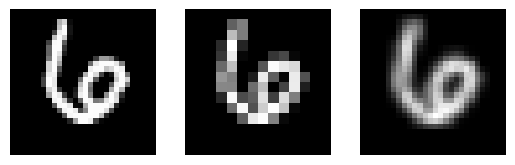

In [6]:
plt.subplot(1,3,1)
plt.imshow(im[0],cmap='gray')
plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(im_down[0],cmap='gray')
plt.axis('off')
plt.subplot(1,3,3)
plt.imshow(im_up[0],cmap='gray')
plt.axis('off')
plt.show()

In [7]:
class Upscale(nn.Module):
  def __init__(self, hidden_units1, hidden_units2):
    super(Upscale, self).__init__()
    self.fc1 = nn.Linear(14*14,hidden_units1)
    self.fc2 = nn.Linear(hidden_units1,hidden_units2)
    self.fc3 = nn.Linear(hidden_units2, 28*28)
  def forward(self,x):
    x = nn.ReLU()(self.fc1(x))
    x = nn.ReLU()(self.fc2(x))
    x = nn.Tanh()(self.fc3(x))
    return x

model = Upscale(256, 512)
im_up_model = model(im_down.flatten()).reshape(28,28)
im_up_model.shape

torch.Size([28, 28])

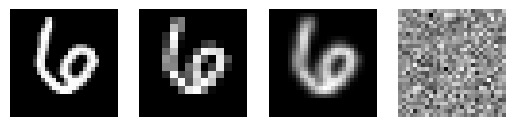

In [8]:
plt.subplot(1,4,1)
plt.imshow(im[0],cmap='gray')
plt.axis('off')
plt.subplot(1,4,2)
plt.imshow(im_down[0],cmap='gray')
plt.axis('off')
plt.subplot(1,4,3)
plt.imshow(im_up[0],cmap='gray')
plt.axis('off')
plt.subplot(1,4,4)
plt.imshow(im_up_model.detach(),cmap='gray')
plt.axis('off')
plt.show()

In [9]:
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr= lr)
loss = nn.MSELoss()
optimizer, loss

(Adam (
 Parameter Group 0
     amsgrad: False
     betas: (0.9, 0.999)
     capturable: False
     differentiable: False
     eps: 1e-08
     foreach: None
     fused: False
     lr: 0.001
     maximize: False
     weight_decay: 0
 ),
 MSELoss())

In [10]:
model.train()
N_epochs = 10
tr_losses=[]
for epoch in range(N_epochs):
  training_loss = 0
  for X, y in train_dl:
    X_down = degrade(X)
    X_up = model(X_down.flatten(start_dim=1))
    loss_val = loss(X.flatten(start_dim=1),X_up)
    training_loss += loss_val.item()
    optimizer.zero_grad()
    loss_val.backward()
    optimizer.step()
  training_loss /= len(train_dl.dataset)
  tr_losses.append(training_loss)
  print(f'{epoch+1:2d}/{N_epochs} loss: {training_loss}')


 1/10 loss: 0.00010572031140327454
 2/10 loss: 5.939956232905388e-05
 3/10 loss: 4.696717212597529e-05
 4/10 loss: 3.897670259078344e-05
 5/10 loss: 3.3293130621314046e-05
 6/10 loss: 2.92199544608593e-05
 7/10 loss: 2.5921713436643284e-05
 8/10 loss: 2.331374337275823e-05
 9/10 loss: 2.136096979180972e-05
10/10 loss: 1.985477643708388e-05


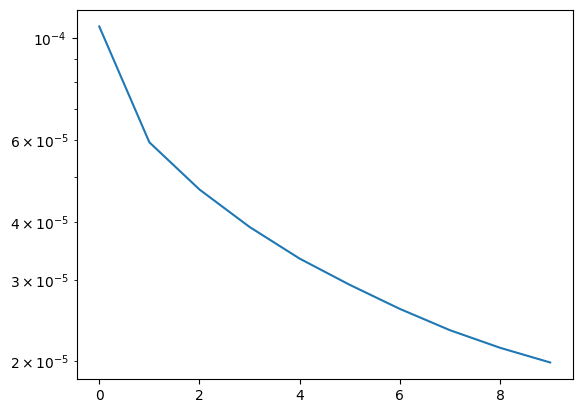

In [11]:
plt.semilogy(tr_losses)
plt.show()

In [12]:
model.eval()
test_loss = 0
for X,y in test_dl:
  X_down = degrade(X)
  X_up = model(X_down.flatten(start_dim=1))
  loss_val = loss(X.flatten(start_dim=1),X_up)
  test_loss += loss_val.item()
print(test_loss / len(test_dl.dataset))

2.250218912959099e-05


In [13]:
for X,y in test_dl:
  break
X = X[:10]
X.shape

torch.Size([10, 1, 28, 28])

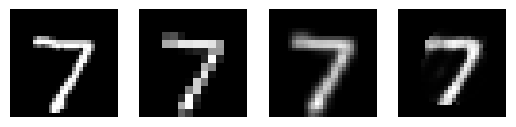

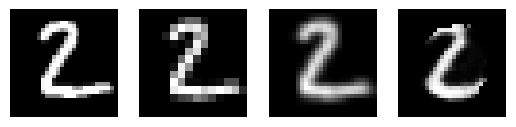

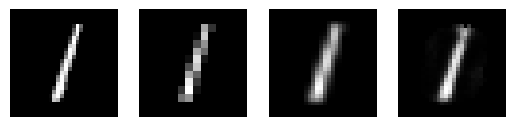

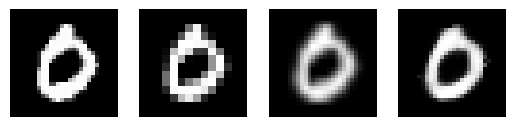

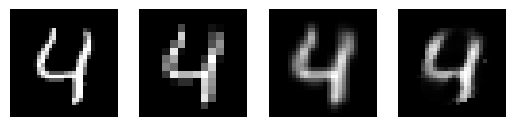

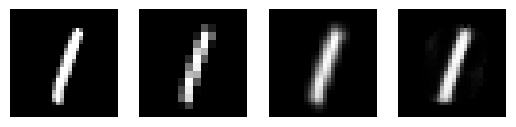

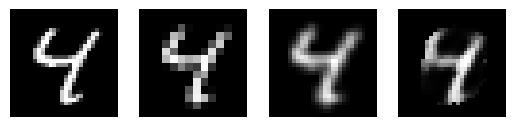

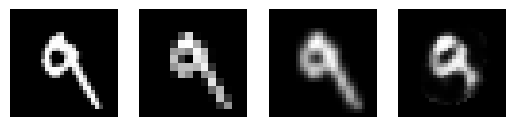

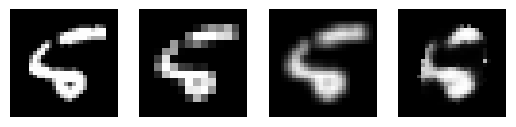

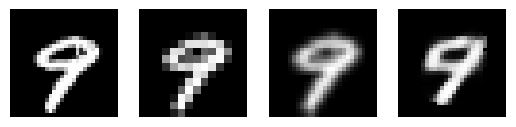

In [14]:
for im in X:
  im_down = degrade(im)
  im_up_linear = linear_upgrade(im_down)
  im_up_model = model(im_down.flatten(start_dim=1)).reshape(28, 28)
  plt.subplot(1,4,1)
  plt.imshow(im[0],cmap='gray')
  plt.axis('off')
  plt.subplot(1,4,2)
  plt.imshow(im_down[0],cmap='gray')
  plt.axis('off')
  plt.subplot(1,4,3)
  plt.imshow(im_up_linear[0],cmap='gray')
  plt.axis('off')
  plt.subplot(1,4,4)
  plt.imshow(im_up_model.detach(),cmap='gray')
  plt.axis('off')
  plt.show()

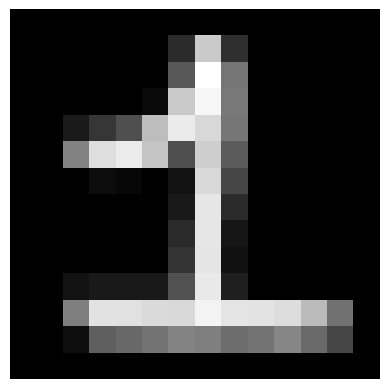

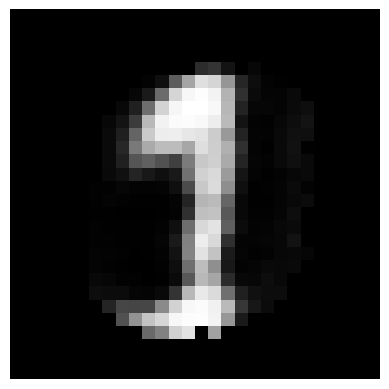

In [15]:
i = Image.open("data/one.png")
i = transform(i)
i = torch.mean(i, 0)
i = -i
plt.imshow(i, cmap='gray')
plt.axis('off')
plt.show()
output = model(i.flatten()).detach()
output = output.view((28,28))
plt.imshow(output, cmap='gray')
plt.axis('off')
plt.show()

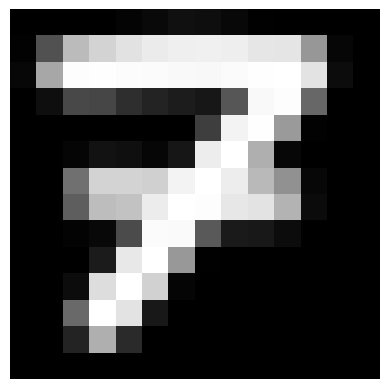

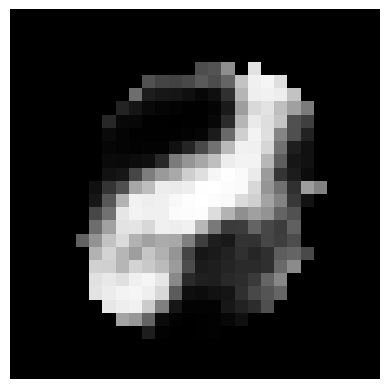

In [17]:
i = Image.open("data/seven.png")
i = transform(i)
i = torch.mean(i, 0)
i = -i
plt.imshow(i, cmap='gray')
plt.axis('off')
plt.show()
output = model(i.flatten()).detach()
output = output.view((28,28))
plt.imshow(output, cmap='gray')
plt.axis('off')
plt.show()